# Приложение "Ненужные вещи"

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Основные задачи исследования:
- Исследовательский анализ: RetationRate, время в приложении,частота действий, конверсия
- Сегментация пользователей
- Проверка статистических гипотез
- Выводы и рекомендации
- Презентация
- Дашборды

Декомпозиция исследования
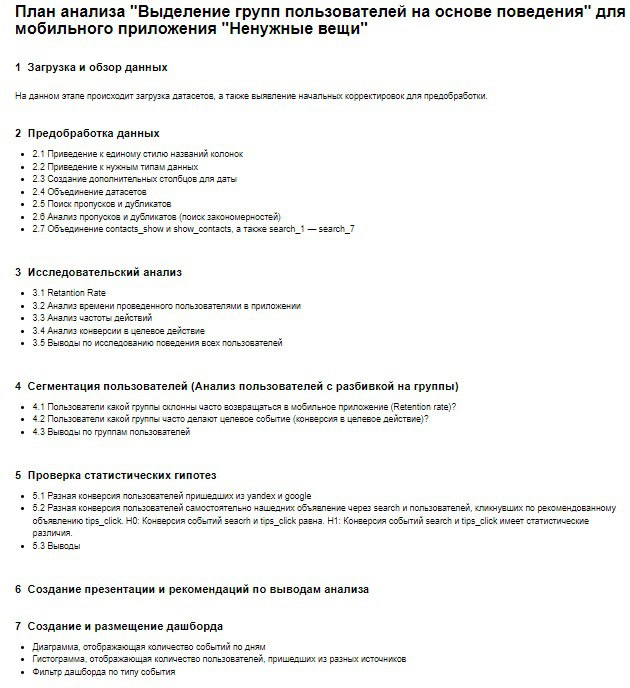

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 8)})
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats as st
import datetime as dt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
pd.set_option('display.max_columns', None)
import os
import plotly.express as px
from plotly import graph_objects as go

### Загрузка и обзор данных

In [2]:
sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv',  parse_dates=['event.time'])

Перед нами 2 датасета
- 1ый sources - индификаторы пользователей и источники(каналы)
- 2ой dataset - события, совершенные пользователи в приложение "Ненужные вещи"
Рассмотрим их подробнее

In [3]:
display(sources.head())
display(sources.info())

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

In [4]:
sources = sources.rename(columns={'userId': 'user_id'})

In [5]:
sources.duplicated().sum()

0

In [6]:
sources.isna().sum()

user_id    0
source     0
dtype: int64

In [7]:
sources

user_id  source
0     020292ab-89bc-4156-9acf-68bc2783f894   other
1     cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2     8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3     d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4     f32e1e2a-3027-4693-b793-b7b3ff274439  google
...                                    ...     ...
4288  b86fe56e-f2de-4f8a-b192-cd89a37ecd41  yandex
4289  424c0ae1-3ea3-4f1e-a814-6bac73e48ab1  yandex
4290  437a4cd4-9ba9-457f-8614-d142bc48fbeb  yandex
4291  c10055f0-0b47-477a-869e-d391b31fdf8f  yandex
4292  d157bffc-264d-4464-8220-1cc0c42f43a9  google

[4293 rows x 2 columns]

Изменили названия колонки, дубликатов и пропусков не обнаружилось

In [8]:
display(dataset.head())
display(dataset.info())

event.time   event.name  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320    tips_show   
2 2019-10-07 00:00:02.245341    tips_show   
3 2019-10-07 00:00:07.039334    tips_show   
4 2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


None

In [9]:
dataset = dataset.rename(columns={'event.time': 'event_time', 'event.name': 'event_name', 'user.id':'user_id'})

In [10]:
dataset.duplicated().sum()

0

In [11]:
dataset.event_time = pd.to_datetime(dataset.event_time, format='%Y.%m.%d %H:%M:%S').dt.round('1S')
dataset['event_date'] = dataset['event_time'].astype('datetime64[D]')

In [12]:
dataset.duplicated().sum()

1118

In [13]:
dataset.isna().sum()

event_time    0
event_name    0
user_id       0
event_date    0
dtype: int64

In [14]:
dataset

event_time   event_name                               user_id  \
0     2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1     2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
2     2019-10-07 00:00:02    tips_show  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
3     2019-10-07 00:00:07    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
4     2019-10-07 00:00:56  advert_open  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
...                   ...          ...                                   ...   
74192 2019-11-03 23:53:30    tips_show  28fccdf4-7b9e-42f5-bc73-439a265f20e9   
74193 2019-11-03 23:54:00    tips_show  28fccdf4-7b9e-42f5-bc73-439a265f20e9   
74194 2019-11-03 23:56:57     search_1  20850c8f-4135-4059-b13b-198d3ac59902   
74195 2019-11-03 23:57:06    tips_show  28fccdf4-7b9e-42f5-bc73-439a265f20e9   
74196 2019-11-03 23:58:13    tips_show  28fccdf4-7b9e-42f5-bc73-439a265f20e9   

      event_date  
0     2019-10-07  
1     2019-10-07  
2     2019-10-07  
3     2019-10-07  
4     2019-10-07  
...          ...  
74192 2019-11-03  
74193 2019-11-03  
74194 2019-11-03  
74195 2019-11-03  
74196 2019-11-03  

[74197 rows x 4 columns]

In [15]:
print(dataset['event_time'].min())
print(dataset['event_time'].max())


2019-10-07 00:00:00
2019-11-03 23:58:13


Привели названия столбцов к нужному формату. Пропусков нет, обнаружилось 1118 дубликатов, с ними разберемся на этапе предобработки данных

### Предобработка данных
Для удобства работы объединим таблицы по user_id

In [16]:
df = dataset.merge(sources, on='user_id', how = 'right')

In [17]:
df

event_time   event_name                               user_id  \
0     2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1     2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
2     2019-10-07 00:00:07    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
3     2019-10-07 00:01:28  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
4     2019-10-07 00:01:35    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
...                   ...          ...                                   ...   
74192 2019-11-03 23:46:47          map  d157bffc-264d-4464-8220-1cc0c42f43a9   
74193 2019-11-03 23:46:59  advert_open  d157bffc-264d-4464-8220-1cc0c42f43a9   
74194 2019-11-03 23:47:01    tips_show  d157bffc-264d-4464-8220-1cc0c42f43a9   
74195 2019-11-03 23:47:47  advert_open  d157bffc-264d-4464-8220-1cc0c42f43a9   
74196 2019-11-03 23:47:50    tips_show  d157bffc-264d-4464-8220-1cc0c42f43a9   

      event_date  source  
0     2019-10-07   other  
1     2019-10-07   other  
2     2019-10-07   other  
3     2019-10-07   other  
4     2019-10-07   other  
...          ...     ...  
74192 2019-11-03  google  
74193 2019-11-03  google  
74194 2019-11-03  google  
74195 2019-11-03  google  
74196 2019-11-03  google  

[74197 rows x 5 columns]

In [18]:
df.to_csv('mobile.csv')

In [19]:
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Объединеям contacts_show и show_contacts, объединяем search

In [20]:
df['event_name'] = df['event_name'].replace({'contacts_show':'show_contacts',
                                            'search_1': 'search',
                                            'search_2': 'search',
                                            'search_3': 'search',
                                            'search_4': 'search',
                                            'search_5': 'search',
                                            'search_6': 'search',
                                            'search_7': 'search'})

In [21]:
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
show_contacts     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

Проверим пропуски и дубликаты

In [22]:
df.isna().sum()

event_time    0
event_name    0
user_id       0
event_date    0
source        0
dtype: int64

In [23]:
df.duplicated().sum()

1190

После объединения появилось еще 72 дубликата, рассмотрим их

In [24]:
df[df.duplicated()]

event_time   event_name                               user_id  \
87    2019-10-16 21:36:12       search  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
324   2019-10-10 04:05:46    tips_show  17f6b2db-2964-4d11-89d8-7e38d2cb4750   
382   2019-10-30 21:37:17       search  57321726-5d66-4d51-84f4-c797c35dcf2b   
761   2019-10-07 11:00:20    tips_show  fb667205-a708-4693-832d-363a30022cfc   
1207  2019-10-07 11:10:40          map  ed13f6f0-08f4-4561-852e-456580f7a40d   
...                   ...          ...                                   ...   
73696 2019-11-03 15:56:43  photos_show  5802f6a5-1842-4ac8-b48b-073828009559   
73697 2019-11-03 15:56:43  photos_show  5802f6a5-1842-4ac8-b48b-073828009559   
73698 2019-11-03 15:56:43  photos_show  5802f6a5-1842-4ac8-b48b-073828009559   
73957 2019-11-03 20:09:47    tips_show  a0944ccf-5813-427a-966e-b146d4e9adbc   
74149 2019-11-03 22:41:01    tips_show  16a5371c-152f-48d8-86fe-5636a931316b   

      event_date  source  
87    2019-10-16  yandex  
324   2019-10-10  yandex  
382   2019-10-30  google  
761   2019-10-07  yandex  
1207  2019-10-07  yandex  
...          ...     ...  
73696 2019-11-03   other  
73697 2019-11-03   other  
73698 2019-11-03   other  
73957 2019-11-03  google  
74149 2019-11-03  yandex  

[1190 rows x 5 columns]

In [25]:
df[df.duplicated()]['event_name'].value_counts()

photos_show      640
tips_show        163
show_contacts    148
map              121
search            90
advert_open       19
contacts_call      3
tips_click         3
favorites_add      3
Name: event_name, dtype: int64

Больше всего дубликатов в событие "photos_chow".
Дубликаты появились из-за округления секунд,такие события с разницей в милисекунды могли появиться из-за технических проблем с интернетом или сервером и одно действие записывалось несколько раз.
Проверим, сколько дубликаты занимают от общего числа событий и можем ли мы их удалить

In [26]:
round(len(df[df.duplicated()])/ len(df)*100, 2)

1.6

1,6 % от общего числа событий, можем удалить дубликаты

In [27]:
df = df.drop_duplicates().reset_index(drop=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73007 entries, 0 to 73006
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  73007 non-null  datetime64[ns]
 1   event_name  73007 non-null  object        
 2   user_id     73007 non-null  object        
 3   event_date  73007 non-null  datetime64[ns]
 4   source      73007 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 2.8+ MB


Для удобства работы, выделим из даты день недели и номер недели

In [29]:
df['week_day'] = df['event_time'].dt.weekday
df['week'] = df['event_time'].dt.isocalendar().week

In [30]:
df.sample(10)

event_time   event_name                               user_id  \
31838 2019-10-31 20:41:25  advert_open  570e1e48-5bfb-4c99-84b6-a10d9a15bf05   
2325  2019-10-21 16:15:37          map  be1449f6-ca45-4f94-93a7-ea4b079b8f0f   
57614 2019-10-26 11:46:30    tips_show  500dcedb-bc38-4f3d-9cd7-e07d542e735e   
67252 2019-10-30 19:44:05  advert_open  bd7df4e8-7551-4b82-b74c-5b22bbda3516   
10752 2019-10-09 14:59:16          map  cbbf0d1b-6f03-4f40-bde0-40ca861f039e   
29297 2019-10-22 12:45:56  advert_open  0561ca40-6325-4fa4-9af3-6310492c1282   
22105 2019-10-13 13:14:06       search  601fb185-0c16-4b6e-bfe3-3b17523b0571   
62280 2019-10-28 11:53:23    tips_show  d725c24f-dc66-4096-bea3-7f33907187a9   
37968 2019-10-18 12:35:05    tips_show  086ac129-e8e1-4875-84ea-a66d84b267d1   
19644 2019-10-12 16:04:29    tips_show  84557d6b-7887-4baf-9281-97c2e0f76e98   

      event_date  source  week_day  week  
31838 2019-10-31   other         3    44  
2325  2019-10-21  google         0    43  
57614 2019-10-26  yandex         5    43  
67252 2019-10-30  google         2    44  
10752 2019-10-09   other         2    41  
29297 2019-10-22  yandex         1    43  
22105 2019-10-13  google         6    41  
62280 2019-10-28  yandex         0    44  
37968 2019-10-18   other         4    42  
19644 2019-10-12  yandex         5    41

Данные готовы для исследовательского анализа

### Исследовательский анализ

#### Retention rate

Добавим дату первой сессии пользователя

In [31]:
first_event_date = df.groupby(['user_id'])['event_date'].min().rename('first_date')
df_rate = df.merge(first_event_date, on='user_id')

In [32]:
first_event_date_1 = df.groupby(['user_id'])['event_time'].min().rename('first_time')
df_rate = df_rate.merge(first_event_date_1, on='user_id')

In [33]:
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73007 entries, 0 to 73006
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  73007 non-null  datetime64[ns]
 1   event_name  73007 non-null  object        
 2   user_id     73007 non-null  object        
 3   event_date  73007 non-null  datetime64[ns]
 4   source      73007 non-null  object        
 5   week_day    73007 non-null  int64         
 6   week        73007 non-null  UInt32        
 7   first_date  73007 non-null  datetime64[ns]
 8   first_time  73007 non-null  datetime64[ns]
dtypes: UInt32(1), datetime64[ns](4), int64(1), object(3)
memory usage: 5.4+ MB


Определеляем lifetime пользователя

In [34]:
df_rate['lifetime'] = (df_rate['event_date'] - df_rate['first_date']).dt.days

In [35]:
df_rate['lifetime_2'] = df_rate['event_date'].dt.isocalendar().week - df_rate['first_date'].dt.isocalendar().week

In [36]:
df_rate['first_week'] = df_rate['first_date'].dt.isocalendar().week

In [37]:
df_rate.sample(10)

event_time     event_name  \
4942  2019-10-20 13:48:17  favorites_add   
61800 2019-10-27 22:50:45         search   
63807 2019-10-28 20:54:06      tips_show   
22033 2019-10-13 12:29:09      tips_show   
45650 2019-10-21 14:48:11      tips_show   
56074 2019-10-25 16:25:34      tips_show   
34706 2019-10-17 10:27:21      tips_show   
15022 2019-10-18 20:45:28      tips_show   
13500 2019-10-10 16:17:57  show_contacts   
62430 2019-10-28 13:08:31    photos_show   

                                    user_id event_date  source  week_day  \
4942   69ec20cc-ca84-4767-99ee-b5864fdde232 2019-10-20  google         6   
61800  fc06dbfc-7414-4253-bdfd-157f247755e2 2019-10-27   other         6   
63807  19d741ba-2bae-4108-8eee-3c72a27b6c0c 2019-10-28  google         0   
22033  11d40f61-52d1-4211-9761-2b123710f390 2019-10-13  google         6   
45650  debf84fa-00f2-46e1-b0d6-56a1c9f2bbac 2019-10-21  yandex         0   
56074  4be4d5ff-9186-405e-938c-c58e1b9eaa45 2019-10-25  yandex         4   
34706  12ef61ea-0ade-4481-a5e6-bf8c6288b40b 2019-10-17  google         3   
15022  72cf08c2-cd3a-4056-8749-a89c6555dc28 2019-10-18  yandex         4   
13500  da2b265a-587c-4dd1-ac4d-7cf4ff459af7 2019-10-10  google         3   
62430  231fbaad-5be4-4e22-9003-283f89ff6358 2019-10-28   other         0   

       week first_date          first_time  lifetime  lifetime_2  first_week  
4942     42 2019-10-07 2019-10-07 21:41:25        13           1          41  
61800    43 2019-10-27 2019-10-27 22:46:41         0           0          43  
63807    44 2019-10-28 2019-10-28 20:30:11         0           0          44  
22033    41 2019-10-13 2019-10-13 12:16:40         0           0          41  
45650    43 2019-10-21 2019-10-21 14:37:15         0           0          43  
56074    43 2019-10-25 2019-10-25 15:41:59         0           0          43  
34706    42 2019-10-17 2019-10-17 09:42:14         0           0          42  
15022    42 2019-10-10 2019-10-10 19:00:52         8           1          41  
13500    41 2019-10-10 2019-10-10 14:23:14         0           0          41  
62430    44 2019-10-28 2019-10-28 12:19:05         0           0          44

Формируем когорты

In [38]:
cohorts = df_rate.groupby(['first_date','lifetime']).agg({'user_id':'nunique'}).reset_index()

In [39]:
cohorts_2 = df_rate.groupby(['first_week','lifetime_2']).agg({'user_id':'nunique'}).reset_index()

In [40]:
cohorts

first_date  lifetime  user_id
0   2019-10-07         0      204
1   2019-10-07         1       37
2   2019-10-07         2       21
3   2019-10-07         3       22
4   2019-10-07         4       14
..         ...       ...      ...
399 2019-11-01         1       15
400 2019-11-01         2        6
401 2019-11-02         0       97
402 2019-11-02         1       15
403 2019-11-03         0      135

[404 rows x 3 columns]

Считаем пользователей на начало периода

In [41]:
users_count = cohorts[cohorts['lifetime'] == 0][['first_date','user_id']]

In [42]:
users_count_2 = cohorts_2[cohorts_2['lifetime_2'] == 0][['first_week','user_id']]

In [43]:
users_count.head()

first_date  user_id
0   2019-10-07      204
28  2019-10-08      167
55  2019-10-09      176
81  2019-10-10      174
106 2019-10-11      136

In [44]:
users_count = users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(users_count, on='first_date')

In [45]:
users_count_2 = users_count_2.rename(columns={'user_id':'cohort_users'})
cohorts_2 = cohorts_2.merge(users_count_2, on='first_week')

Считаем retention

In [46]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']

In [47]:
cohorts_2['retention'] = cohorts_2['user_id']/cohorts_2['cohort_users']

Оставим только дату

In [48]:
cohorts['first_date'] = cohorts['first_date'].dt.date

Создавем сводную таблицу с retention 

In [49]:
t = cohorts.pivot_table(index='first_date', columns='lifetime', values='retention', aggfunc='sum')

In [50]:
t_2 = cohorts_2.pivot_table(index='first_week', columns='lifetime_2', values='retention', aggfunc='sum')

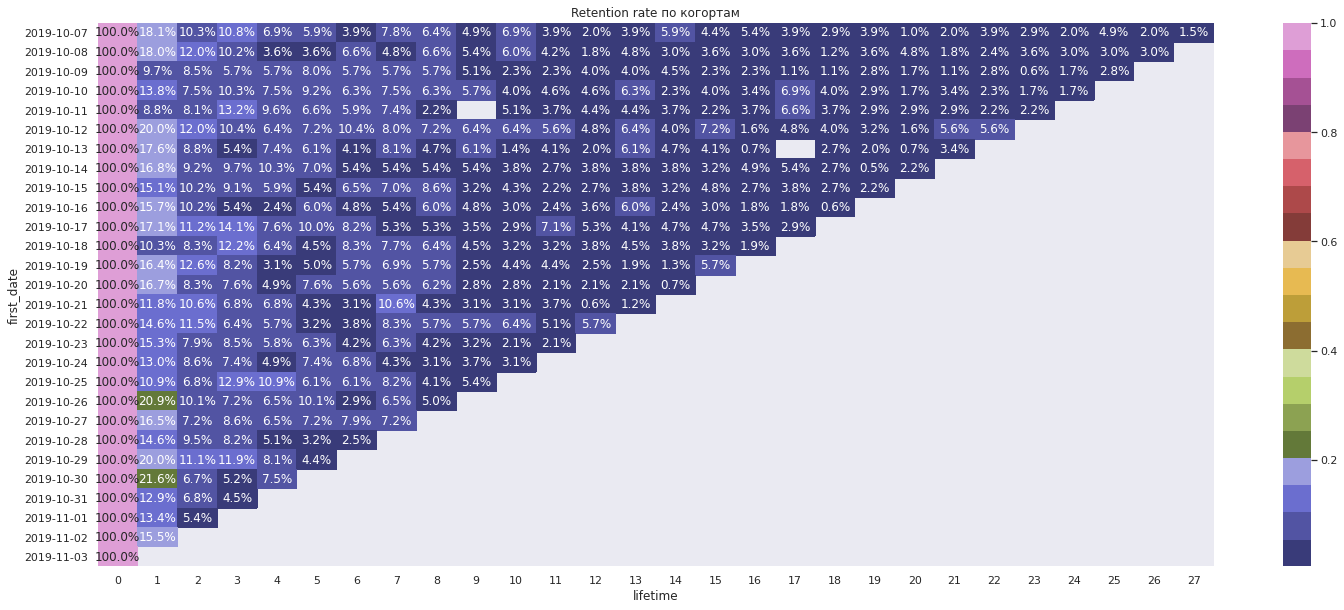

In [51]:
plt.figure(figsize=(25, 10))
plt.title('Retention rate по когортам')
sns.heatmap(t, annot=True, fmt='.1%', cmap="tab20b");

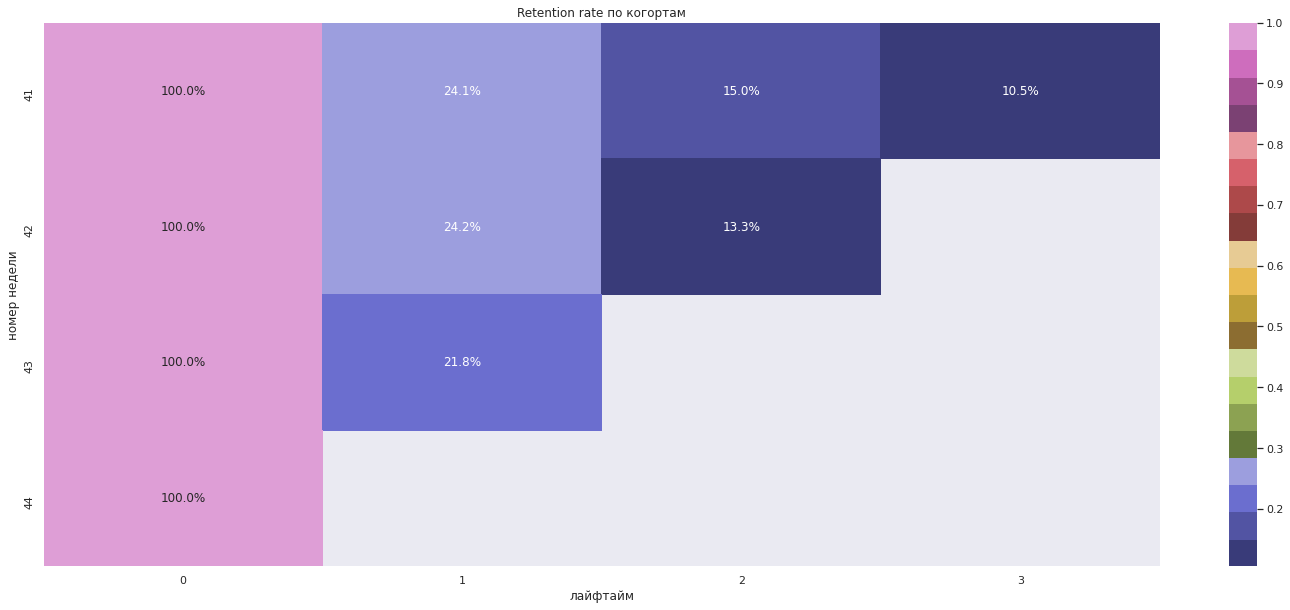

In [52]:
plt.figure(figsize=(25, 10))
plt.title('Retention rate по когортам')
sns.heatmap(t_2, annot=True, fmt='.1%', cmap="tab20b")
plt.xlabel('лайфтайм')
plt.ylabel('номер недели');

По графику видно стремительное падение коэфицэнта удержания пользователей. Около 15% пользователей возвращаются в приложении в течении первых 3 дней. К 10 дню в приложении остается около 5% пользователей от старта когорты. к 20 дню в приложении остается в среднем 2,5% пользователей

#### Анализ проведенного времени в приложении

V2
Определим время количество сессий для каждого пользователя, если между сессиями более 30 минут, то это начало для другой сессии
Промежуток между сессиями воззьмем за 30 мин. т.к. ни одно из действий в event_name  не может занимать так много времени. Если пользователь пол часа не проявлял никакую активность, то значит он отложил приложение( свернул, закрыл), а значит следущая активность будет следущей сессией

In [53]:
df_time = df.sort_values(['user_id', 'event_time'])

In [54]:
session = (df_time.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()

In [55]:
df_time['session_id'] = df.groupby(['user_id', session], sort=False).ngroup() + 1

In [56]:
session_duration = pd.DataFrame(df_time.groupby(['user_id', 'session_id','event_name'])['event_time'].max() - df_time.groupby(['user_id', 'session_id'])['event_time'].min()).reset_index()

In [57]:
session_duration['duration'] = session_duration['event_time'].astype('timedelta64[m]')
session_duration

user_id  session_id     event_name  \
0      0001b1d5-b74a-4cbf-aeb0-7df5947bf349         251      tips_show   
1      0001b1d5-b74a-4cbf-aeb0-7df5947bf349         252            map   
2      0001b1d5-b74a-4cbf-aeb0-7df5947bf349         252      tips_show   
3      0001b1d5-b74a-4cbf-aeb0-7df5947bf349         253            map   
4      0001b1d5-b74a-4cbf-aeb0-7df5947bf349         253      tips_show   
...                                     ...         ...            ...   
17849  fffb9e79-b927-4dbb-9b48-7fd09b23a62b        2689      tips_show   
17850  fffb9e79-b927-4dbb-9b48-7fd09b23a62b        2690  show_contacts   
17851  fffb9e79-b927-4dbb-9b48-7fd09b23a62b        2690      tips_show   
17852  fffb9e79-b927-4dbb-9b48-7fd09b23a62b        2691  show_contacts   
17853  fffb9e79-b927-4dbb-9b48-7fd09b23a62b        2691      tips_show   

           event_time  duration  
0     0 days 00:09:56       9.0  
1     0 days 00:01:32       1.0  
2     0 days 00:08:27       8.0  
3     0 days 00:04:18       4.0  
4     0 days 00:14:59      14.0  
...               ...       ...  
17849 0 days 00:04:56       4.0  
17850 0 days 00:09:30       9.0  
17851 0 days 00:15:48      15.0  
17852 0 days 00:15:57      15.0  
17853 0 days 00:32:24      32.0  

[17854 rows x 5 columns]

Соберем данные по пользователям, узнаем сколько пользователь тратит время на сессию, и сколько всего провел времени в приложении

In [58]:
t = session_duration.groupby(['user_id'])['duration'].agg({'sum', 'mean'}).reset_index()
t

user_id    sum       mean
0     0001b1d5-b74a-4cbf-aeb0-7df5947bf349   55.0   7.857143
1     00157779-810c-4498-9e05-a1e9e3cedf93  591.0  31.105263
2     00463033-5717-4bf1-91b4-09183923b9df   24.0  24.000000
3     004690c3-5a84-4bb7-a8af-e0c8f8fca64e  181.0  13.923077
4     00551e79-152e-4441-9cf7-565d7eb04090   18.0   3.000000
...                                    ...    ...        ...
4288  ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07   49.0  12.250000
4289  ffc01466-fdb1-4460-ae94-e800f52eb136    0.0   0.000000
4290  ffcf50d9-293c-4254-8243-4890b030b238    1.0   0.500000
4291  ffe68f10-e48e-470e-be9b-eeb93128ff1a   57.0   9.500000
4292  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  948.0  18.588235

[4293 rows x 3 columns]

In [59]:
t['mean'].describe()

count    4293.000000
mean       11.174787
std        13.703092
min         0.000000
25%         2.666667
50%         7.000000
75%        14.600000
max       233.250000
Name: mean, dtype: float64

In [60]:
t['sum'].describe()

count    4293.000000
mean       48.952015
std       120.810977
min         0.000000
25%         6.000000
50%        19.000000
75%        47.000000
max      2849.000000
Name: sum, dtype: float64

Построим графики для более наглядного понимания

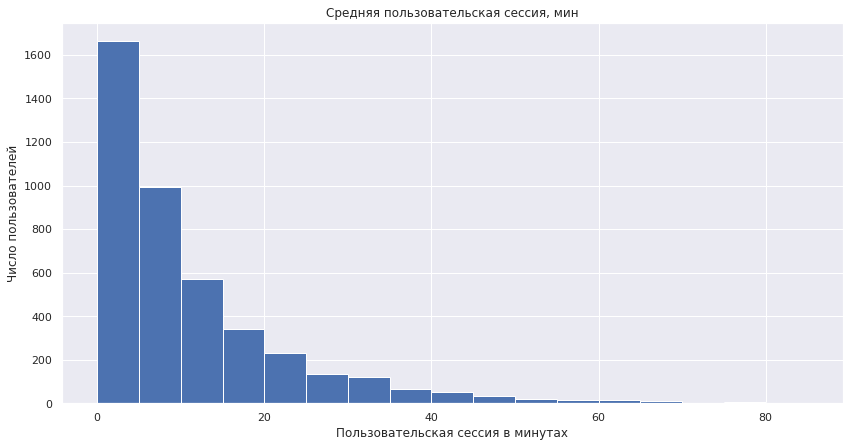

In [61]:
t['mean'].hist(bins = 17, figsize = (14, 7), range = (0, 85))
plt.title('Средняя пользовательская сессия, мин')
plt.xlabel('Пользовательская сессия в минутах')
plt.ylabel('Число пользователей');

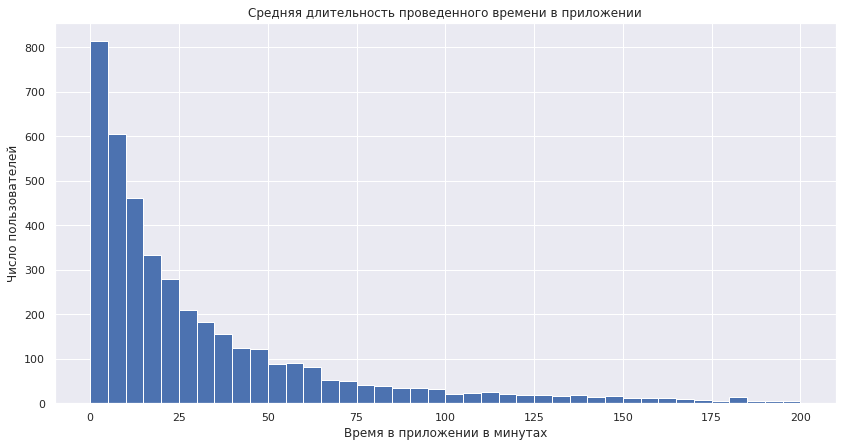

In [62]:
t['sum'].hist(bins = 40, figsize = (14, 7), range = (0, 200))
plt.title('Средняя длительность проведенного времени в приложении')
plt.xlabel('Время в приложении в минутах')
plt.ylabel('Число пользователей');

Среднее время сессии 14 минут, а среднее время проведенное пользователями за период анализа - 30 минут, но если посмотреть на медиану, то медианное время сессии - 9 минут, а медианное время в приложении всего 14 минут, мы наблюдаем существенную разницу между медианным и средним значением, а значит в данных большое количество выбросов, искажающих результаты. На графиках видно, что большая часть сессий длится менее 5 минут, как и время, проведенное в приложении, не превышает 5 минут.

In [63]:
t = session_duration[session_duration['duration'] < 1]
t = pd.DataFrame(t['event_name'].value_counts())

In [64]:
fig = px.bar(t['event_name'])
fig.update_layout(title='Распределение действий пользователей в сессиях длительностью менее 1 минуты')      
fig.show() 

В сессиях менее 1 минуты чаще всего совершается действие search, около 1800 значений, а также tips_show-1342. Возможно, из-за некоректной работы поиска или предложенных объявлений.

#### Анализ частоты действий

Соберем данные по дням и по неделям с разбивкой на действия

In [65]:
df_event = df.groupby(['event_date','event_name']).agg({'event_time':'count'}).reset_index()

In [66]:
df_event_week = df.groupby(['week' , 'event_name']).agg({'event_time':'count'}).reset_index()

In [67]:
df_event_weekday = df.groupby(['week_day' , 'event_name']).agg({'event_time':'count'}).reset_index()

In [68]:
df_event = df_event.sort_values('event_date')
df_event_week = df_event_week.sort_values('week')

In [69]:
df_event.columns = ['date', 'event_name', 'event_count']
df_event_week.columns = ['week', 'event_name', 'event_count']
df_event_weekday.columns = ['week_day', 'event_name','event_count']

In [70]:
df_event = df_event.sort_values('date')
df_event_week = df_event_week.sort_values('week')
df_event_weekday= df_event_weekday.sort_values('week_day')

In [71]:
fig = px.bar(df_event_week, x='week', y='event_count', color='event_name')
fig.update_layout(title='Анализ совершенных событий по неделям')      
fig.show() 

In [72]:
fig = px.bar(df_event, x='date', y='event_count', color='event_name')
fig.update_layout(title='Анализ совершенных событий по дням')      
fig.show() 

In [73]:
fig = px.bar(df_event_weekday, x='week_day', y='event_count', color='event_name')
fig.update_layout(title='Анализ совершенных событий по дням недели')      
fig.show() 

Активность пользователей была максимальной на 43 неделе 2019 года (21-27 октября), есть заметное снижение активности пользователей в пятницу и субботу, а также рост активности в начале неделе. Логично предположить, что это связанно с рабочими задачи в первой половине недели и выходными:)

In [74]:
df_event_count = pd.DataFrame(df['event_name'].value_counts())

In [75]:
fig = px.bar(df_event_count, y= 'event_name', color = df_event_count.index)
fig.update_layout(title='Анализ совершенных событий за все время')      
fig.show() 

#### Анализ конверсии в целевое действие

Для нашего анализа было определено целевое действие - show_contact, найдет процент пользователей совершивших, целевое дейтсвие

In [76]:
df[df['event_name'] == 'show_contacts']['user_id'].nunique()

981

In [77]:
round(df[df['event_name'] == 'show_contacts']['user_id'].nunique() / df['user_id'].nunique() * 100, 1)

22.9

23% пользователей совершили целевое действие за представленный период

In [78]:
target_actions = df_rate.query('event_name == "show_contacts"')
target_actions = target_actions[['user_id', 'event_time']]
target_actions.rename(columns={'event_time': 'event_dt'}, inplace=True)
target_actions['event_dt'] = pd.to_datetime(target_actions['event_dt'])
target_actions

user_id            event_dt
121    8c356c42-3ba9-4cb6-80b8-3f868d0192c3 2019-10-07 00:05:16
135    8c356c42-3ba9-4cb6-80b8-3f868d0192c3 2019-10-07 00:18:53
348    17f6b2db-2964-4d11-89d8-7e38d2cb4750 2019-10-20 02:39:00
353    17f6b2db-2964-4d11-89d8-7e38d2cb4750 2019-10-20 02:44:58
410    48e614d6-fe03-40f7-bf9e-4c4f61c19f64 2019-10-07 08:11:08
...                                     ...                 ...
72832  8cb7761d-ea9f-4631-b4b8-90e6bd30848b 2019-11-03 20:56:09
72833  8cb7761d-ea9f-4631-b4b8-90e6bd30848b 2019-11-03 20:57:54
72834  8cb7761d-ea9f-4631-b4b8-90e6bd30848b 2019-11-03 20:58:17
72847  da4b7af3-c603-457a-8506-71d90077417b 2019-11-03 22:13:18
72997  c10055f0-0b47-477a-869e-d391b31fdf8f 2019-11-03 23:46:31

[4381 rows x 2 columns]

In [79]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_time <= @last_suitable_acquisition_date')

    # определяем дату и время первого целевого действия для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о целевых действиях 
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждого целевого действия
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_time']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_time'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

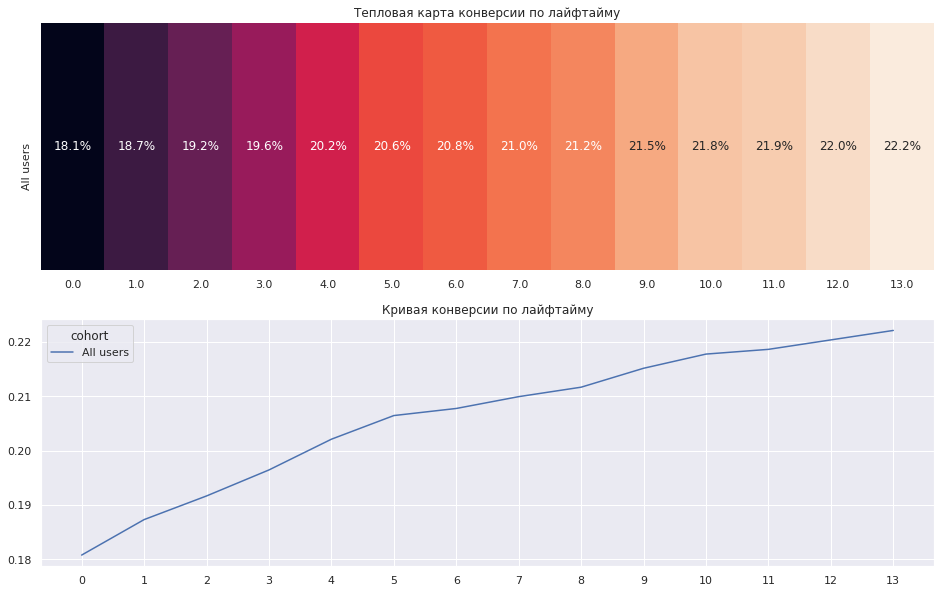

In [80]:
# считаем конверсию без параметра dimensions
conversion_raw, conversion, conversion_history = get_conversion(
    df_rate, target_actions, datetime(2019, 11, 3), 14
)


plt.figure(figsize = (16, 10)) # задаём размер «подложки»

# исключаем размеры когорт
# конверсии первого дня различаются, их удалять не нужно
report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, cbar=False, fmt='.1%', ax=plt.subplot(2, 1, 1)
)  # в первой ячейке таблицы графиков строим тепловую карту
plt.title('Тепловая карта конверсии по лайфтайму')
plt.ylabel('')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(2, 1, 2)
)  # во второй — кривые конверсии
plt.title('Кривая конверсии по лайфтайму')

plt.show() 

По графикам видно, что конверсия пользователей в целове действие (show_contscts) активно росла до 7 го дня, дальше рост замедлился

#### Выводы по исследовательскому анализу:
- уже ко второй неделе коэфициент удержания снижается до 0,2, только 20 пользователей возвращаются в приложение в течении следующей недели, а к 4ой недели в приложении остается только 10% от первоначального числа
- медианное время одной сессии - около 9 минут, а медиана общего проведенного времени в приложении за время анализа около 14 минут
- активность пользователей проявляется в начале недели и снижается к выходным, 54% всех событий приходится на tips_show, 0,7% - contact_call
- 23% пользователей совершили целевой действие за предоставленный период

### Сегментация пользователей (Анализ с разбивкой по группам)

Сегментация пользователей по временным промежуткам дня поможет лучше определить период активности пользователей, что поможет скоректировать таргетированную рекламу, пуш - уведомления, а также возможности улучшения интерфейса и дизайна приложения для определенных временных промежутков, например ночной режим приложения, он может увеличить лояльсть и удержание пользователей, но пока рано делать выводы

In [81]:
def time_of_day(hour):
    if  hour >= 4 and hour <= 12:
        return 'morning'
    elif hour > 12 and hour <= 20:
        return 'day'
    else:
        return 'night'

In [82]:
df_rate['hour'] = df_rate['first_time'].dt.hour

In [83]:
df_rate['segment'] = df_rate['hour'].apply(time_of_day)

In [84]:
df_1 = df_rate[df_rate['segment'] == "morning"]
df_2 = df_rate[df_rate['segment'] == "day"]
df_3 = df_rate[df_rate['segment'] == "night"]

Группы разделены следующим образом:
- df_1 с 04:00 по 12:00 утреняя группа
- df_2 c 12:00 по 20:00 дневная группа
- df_3 c 20:00 по 04:00 ночная группа

Количество уникальных пользователей и количество событий в каждой группе, процент отвсех событий исследования

In [85]:
print('Количество уникальных пользователей в группе:', df_1['user_id'].nunique())
print('Количество событий группы', len(df_1))
print('Процент от общего колиечества событий', round(len(df_1)/len(df)*100,1))

Количество уникальных пользователей в группе: 1268
Количество событий группы 21202
Процент от общего колиечества событий 29.0


In [86]:
print('Количество уникальных пользователей в группе:', df_2['user_id'].nunique())
print('Количество событий группы', len(df_2))
print('Процент от общего колиечества событий', round(len(df_2)/len(df)*100,1))

Количество уникальных пользователей в группе: 2188
Количество событий группы 37844
Процент от общего колиечества событий 51.8


In [87]:
print('Количество уникальных пользователей в группе:', df_3['user_id'].nunique())
print('Количество событий группы', len(df_3))
print('Процент от общего колиечества событий', round(len(df_3)/len(df)*100,1))

Количество уникальных пользователей в группе: 837
Количество событий группы 13961
Процент от общего колиечества событий 19.1


In [88]:
df_1['user_id'].nunique()

1268

In [89]:
df_2['user_id'].nunique()

2188

In [90]:
df_3['user_id'].nunique()

837

In [91]:
df_1['user_id'].nunique() + df_2['user_id'].nunique()+ df_3['user_id'].nunique()

4293

#### Пользователи какой группы чаще возвращаются в приложение (Retention_rate)

In [92]:
def ret_rate(data):
    
    # определяем когорты
    cohorts_2 = data.groupby(['first_week','lifetime_2']).agg({'user_id':'nunique'}).reset_index()
    
    # создаем первоначальные размеры когорт
    users_count_2 = cohorts_2[cohorts_2['lifetime_2'] == 0][['first_week','user_id']]
    users_count_2 = users_count_2.rename(columns={'user_id':'cohort_users'})
    cohorts_2 = cohorts_2.merge(users_count_2, on='first_week')
    
    # считаем retention
    cohorts_2['retention'] = cohorts_2['user_id']/cohorts_2['cohort_users']
    
    # создаем таблицу для графика
    t_2 = cohorts_2.pivot_table(index='first_week', columns='lifetime_2', values='retention', aggfunc='sum')
    
    # строим график
    plt.figure(figsize=(25, 10))
    plt.title('Retention rate по когортам')
    sns.heatmap(t_2, annot=True, fmt='.1%', cmap="tab20b")
    plt.xlabel('лайфтайм')
    plt.ylabel('номер недели')
    plt.show

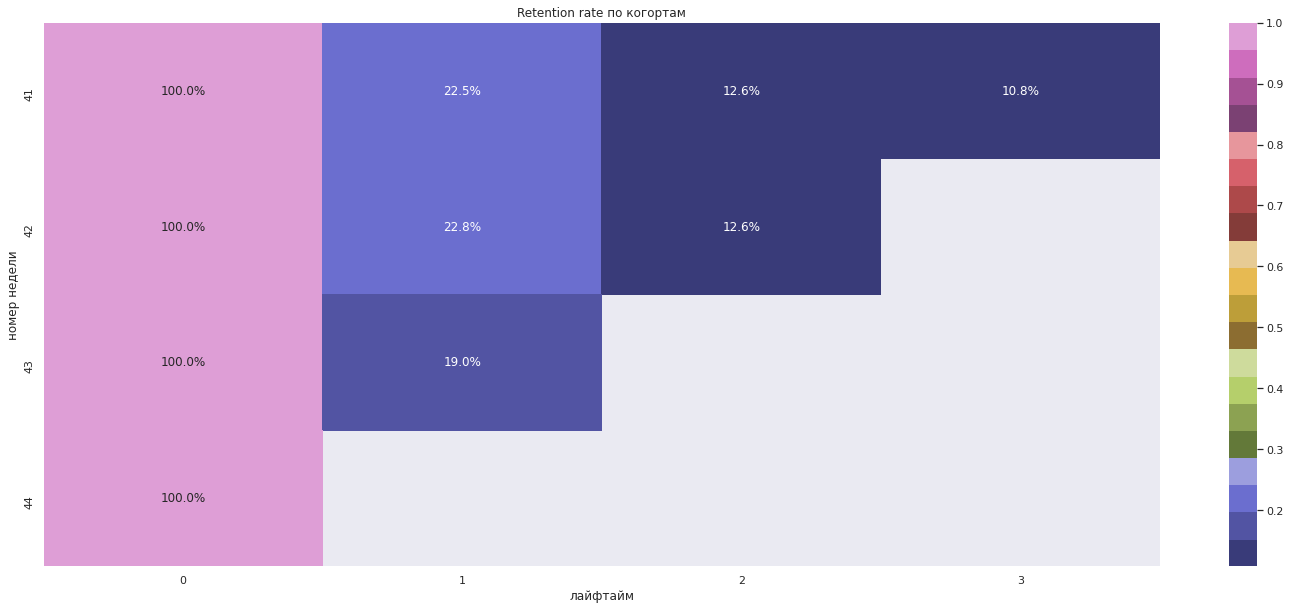

In [93]:
ret_rate(df_1)

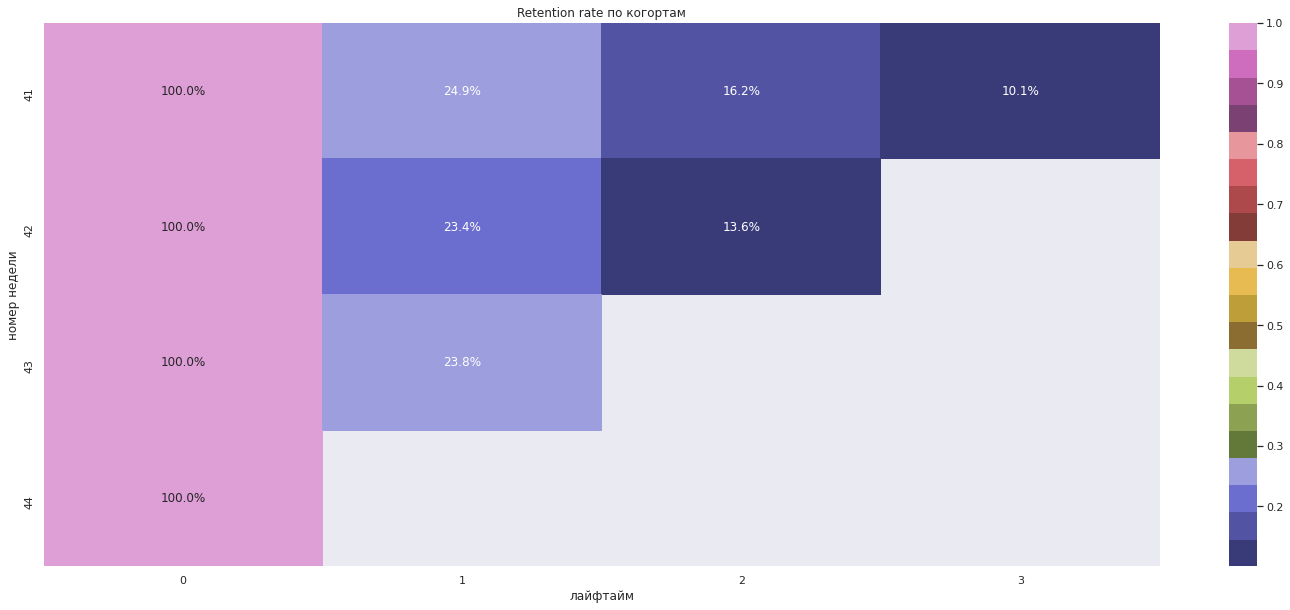

In [94]:
ret_rate(df_2)

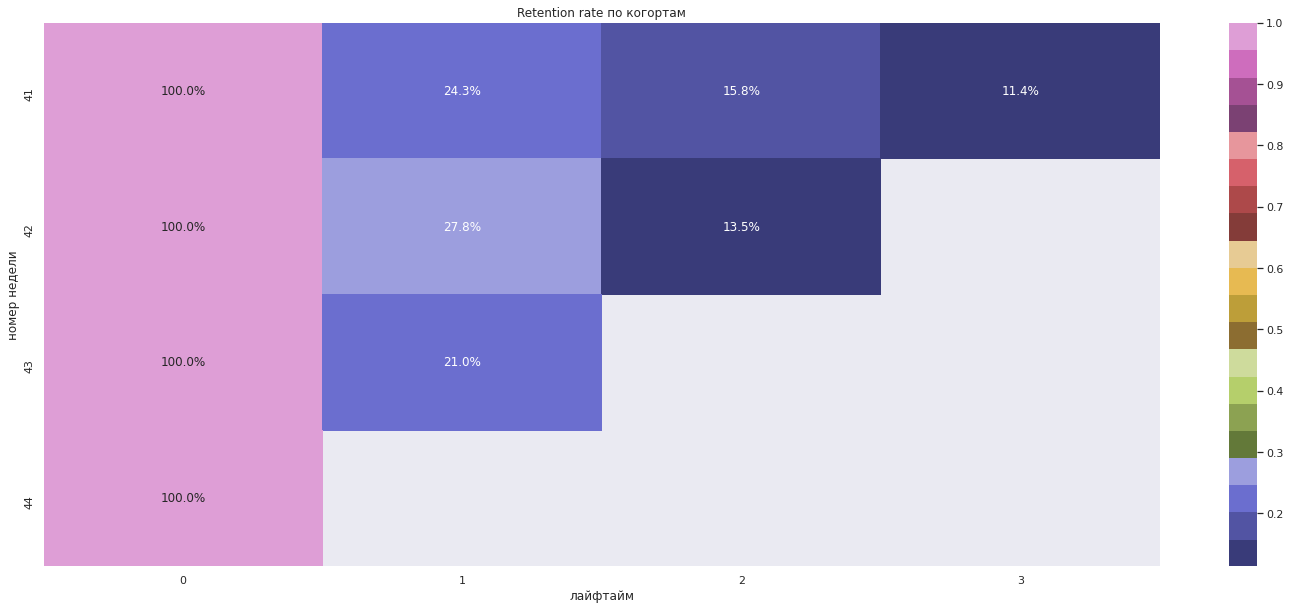

In [95]:
ret_rate(df_3)

V2
Все группы имеют примерно одинаковое удержание, на второй недели ночная группа выигрывает на пару процентов, что не существено в общей картине удержания пользователей

#### Пользователи какой группы чаще совершают целевое событие

In [96]:
round(df_1[df_1['event_name'] == 'show_contacts']['user_id'].nunique() / df_1['user_id'].nunique() * 100, 1)

23.7

In [97]:
round(df_2[df_2['event_name'] == 'show_contacts']['user_id'].nunique() / df_2['user_id'].nunique() * 100, 1)

24.1

In [98]:
round(df_3[df_3['event_name'] == 'show_contacts']['user_id'].nunique() / df_3['user_id'].nunique() * 100, 1)

18.4

In [99]:
target_actions_1 = df_1.query('event_name == "show_contacts"')
target_actions_1 = target_actions_1[['user_id', 'event_time']]
target_actions_1.rename(columns={'event_time': 'event_dt'}, inplace=True)
target_actions_1['event_dt'] = pd.to_datetime(target_actions_1['event_dt'])
target_actions_1

user_id            event_dt
410    48e614d6-fe03-40f7-bf9e-4c4f61c19f64 2019-10-07 08:11:08
826    9dfa242e-8630-480a-806b-5736bcda8f3d 2019-10-07 09:33:20
828    9dfa242e-8630-480a-806b-5736bcda8f3d 2019-10-07 15:31:00
948    f60a4cd4-f82c-4897-9804-3b7b130b15ac 2019-10-08 10:40:11
1040   21b9ef95-e152-47e6-bb4b-284525c38064 2019-10-07 11:11:51
...                                     ...                 ...
72058  b0e9217b-672e-4208-b689-1bd14a87920e 2019-11-03 12:12:51
72059  b0e9217b-672e-4208-b689-1bd14a87920e 2019-11-03 12:18:12
72061  b0e9217b-672e-4208-b689-1bd14a87920e 2019-11-03 12:21:30
72128  b52f8e6b-d979-4d14-87e9-6ff38e89ef9c 2019-11-03 12:41:27
72134  b52f8e6b-d979-4d14-87e9-6ff38e89ef9c 2019-11-03 13:16:08

[1532 rows x 2 columns]

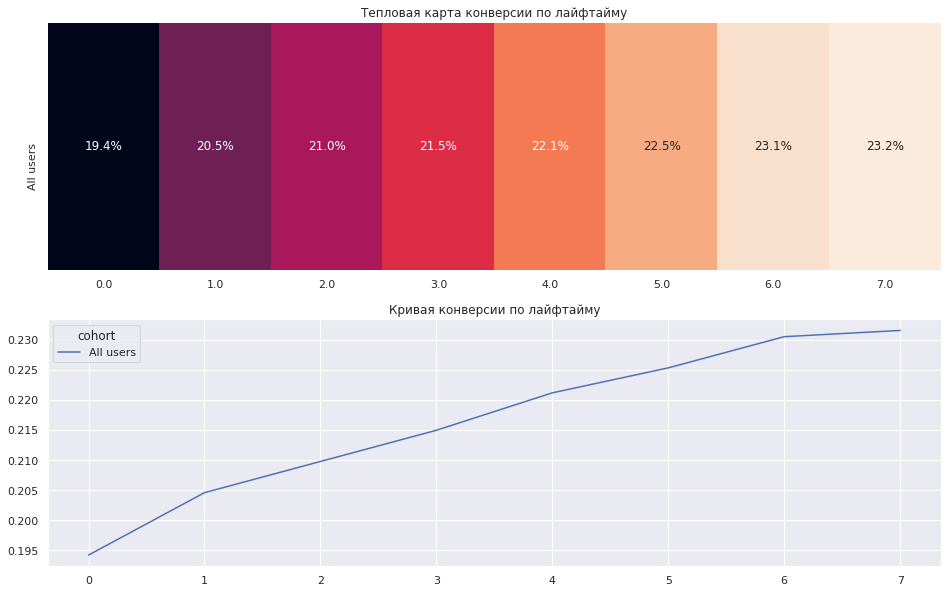

In [100]:
# считаем конверсию без параметра dimensions
conversion_raw, conversion, conversion_history = get_conversion(
    df_1, target_actions_1, datetime(2019, 11, 3), 8)


plt.figure(figsize = (16, 10)) # задаём размер «подложки»

# исключаем размеры когорт
# конверсии первого дня различаются, их удалять не нужно
report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, cbar=False, fmt='.1%', ax=plt.subplot(2, 1, 1)
)  # в первой ячейке таблицы графиков строим тепловую карту
plt.title('Тепловая карта конверсии по лайфтайму')
plt.ylabel('')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(2, 1, 2)
)  # во второй — кривые конверсии
plt.title('Кривая конверсии по лайфтайму')

plt.show() 

In [101]:
target_actions_2 = df_2.query('event_name == "show_contacts"')
target_actions_2 = target_actions_2[['user_id', 'event_time']]
target_actions_2.rename(columns={'event_time': 'event_dt'}, inplace=True)
target_actions_2['event_dt'] = pd.to_datetime(target_actions_2['event_dt'])

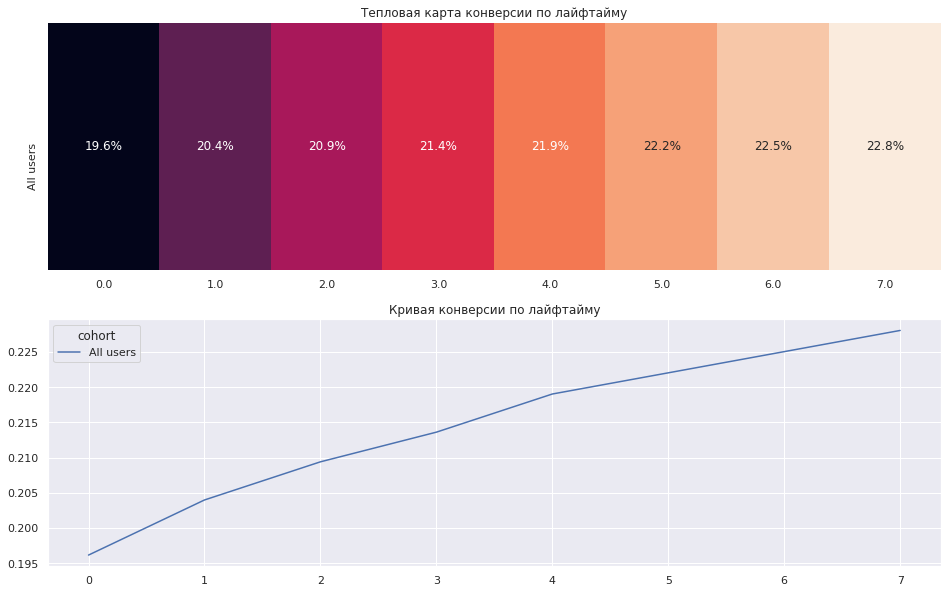

In [102]:
# считаем конверсию без параметра dimensions
conversion_raw, conversion, conversion_history = get_conversion(
    df_2, target_actions_2, datetime(2019, 11, 3), 8)


plt.figure(figsize = (16, 10)) # задаём размер «подложки»

# исключаем размеры когорт
# конверсии первого дня различаются, их удалять не нужно
report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, cbar=False, fmt='.1%', ax=plt.subplot(2, 1, 1)
)  # в первой ячейке таблицы графиков строим тепловую карту
plt.title('Тепловая карта конверсии по лайфтайму')
plt.ylabel('')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(2, 1, 2)
)  # во второй — кривые конверсии
plt.title('Кривая конверсии по лайфтайму')

plt.show() 

In [103]:
target_actions_3 = df_3.query('event_name == "show_contacts"')
target_actions_3 = target_actions_3[['user_id', 'event_time']]
target_actions_3.rename(columns={'event_time': 'event_dt'}, inplace=True)
target_actions_3['event_dt'] = pd.to_datetime(target_actions_3['event_dt'])

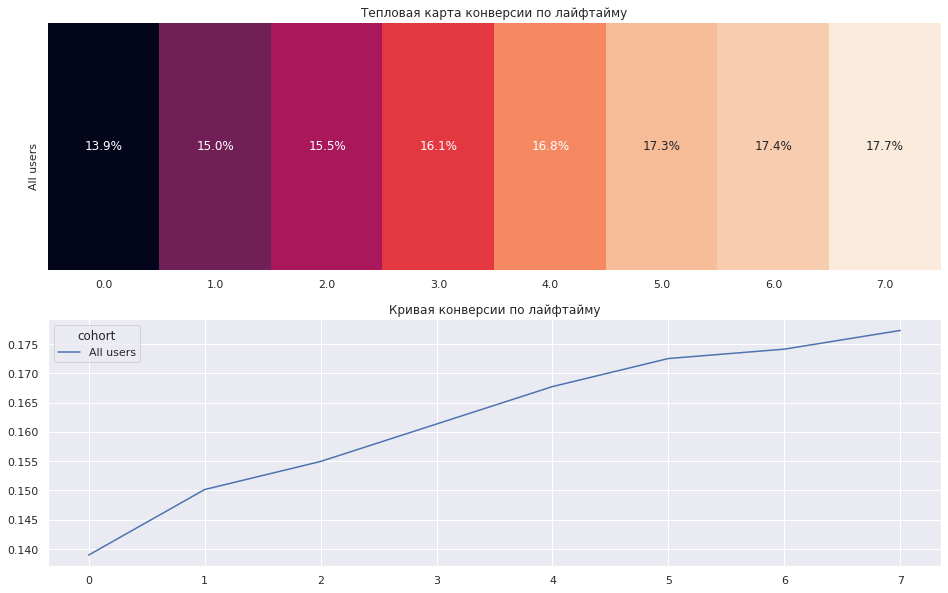

In [104]:
# считаем конверсию без параметра dimensions
conversion_raw, conversion, conversion_history = get_conversion(
    df_3, target_actions_3, datetime(2019, 11, 3), 8)


plt.figure(figsize = (16, 10)) # задаём размер «подложки»

# исключаем размеры когорт
# конверсии первого дня различаются, их удалять не нужно
report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, cbar=False, fmt='.1%', ax=plt.subplot(2, 1, 1)
)  # в первой ячейке таблицы графиков строим тепловую карту
plt.title('Тепловая карта конверсии по лайфтайму')
plt.ylabel('')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(2, 1, 2)
)  # во второй — кривые конверсии
plt.title('Кривая конверсии по лайфтайму')

plt.show() 

v2
Конверсия утренеей группы - примерно 24%, дневной - 24%, и ночной -18%, целейвой группой являетсяс дневная группа, т.к. в ней больше пользователей при чуть большей конверсии. Группа 3(ночная) демонструет самые низкие показатели как по конверсии, так и по количеству пользователей

### Проверка статистических гипотез

#### Конверсия пользователей пришедших их Google  и Яндекс

In [105]:
df_time['target_action'] = df_time['event_name'] == 'show_contacts'
df_time['target_action'] = df_time['target_action'].astype(int)

In [106]:
df_time['search_action'] = df_time['event_name'] == 'search'
df_time['search_action'] = df_time['search_action'].astype(int)

In [107]:
df_time['tips_action'] = df_time['event_name'] == 'tips_click'
df_time['tips_action'] = df_time['tips_action'].astype(int)

In [108]:
df_source = df_time.groupby('user_id').agg({'session_id':'count','target_action':'sum','search_action':'sum', 'tips_action':'sum'})

In [109]:
df_source['conversion'] = round(df_source['target_action'] / df_source['session_id'],2)

In [110]:
source_conversion = df_source.merge(sources, on='user_id', how = 'right')
source_conversion

user_id  session_id  target_action  \
0     020292ab-89bc-4156-9acf-68bc2783f894          28              0   
1     cf7eda61-9349-469f-ac27-e5b6f5ec475c          92              0   
2     8c356c42-3ba9-4cb6-80b8-3f868d0192c3          96              2   
3     d9b06b47-0f36-419b-bbb0-3533e582a6cb           8              0   
4     f32e1e2a-3027-4693-b793-b7b3ff274439          33              0   
...                                    ...         ...            ...   
4288  b86fe56e-f2de-4f8a-b192-cd89a37ecd41           6              0   
4289  424c0ae1-3ea3-4f1e-a814-6bac73e48ab1           5              0   
4290  437a4cd4-9ba9-457f-8614-d142bc48fbeb           4              0   
4291  c10055f0-0b47-477a-869e-d391b31fdf8f           5              1   
4292  d157bffc-264d-4464-8220-1cc0c42f43a9           5              0   

      search_action  tips_action  conversion  source  
0                 0            0        0.00   other  
1                 3            2        0.00  yandex  
2                 2            3        0.02  yandex  
3                 2            0        0.00   other  
4                 0            0        0.00  google  
...             ...          ...         ...     ...  
4288              0            0        0.00  yandex  
4289              0            0        0.00  yandex  
4290              0            0        0.00  yandex  
4291              0            4        0.20  yandex  
4292              0            0        0.00  google  

[4293 rows x 7 columns]

In [111]:
source_yandex = source_conversion.query('source == "yandex"')
source_google = source_conversion.query('source == "google"')

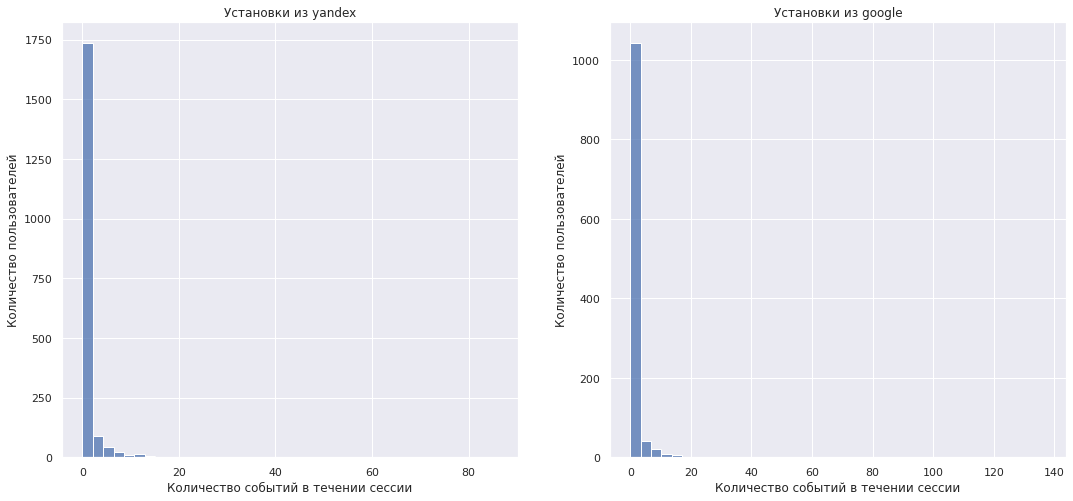

In [112]:
fig = plt.figure(figsize=(18,8))
area = fig.add_subplot(1, 2, 1)
ax = sns.histplot(source_yandex['target_action'],bins = 40)
ax.set_title("Установки из yandex")
ax.set_xlabel("Количество событий в течении сессии")
ax.set_ylabel("Количество пользователей")

area = fig.add_subplot(1, 2, 2)
ax = sns.histplot(source_google['target_action'], bins = 40 )
ax.set_title("Установки из google")
ax.set_xlabel("Количество событий в течении сессии")
ax.set_ylabel("Количество пользователей");

Сформулируем гипотезы:
- Н0: Конверсия в целевое действие пользователей, пришедших из каналов яндекс и гугл, равна
- Н1: Конверсия пользователей имеет статистические различия

In [113]:
alpha = 0.05

results = st.ttest_ind(
    source_yandex['conversion'], 
    source_google['conversion'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8225997563641054
Не получилось отвергнуть нулевую гипотезу


In [114]:
print('Средняя конверсия в целевое действие у пользователей yandex: {:.2%}'.format(source_yandex['conversion'].mean()))
print('Средняя конверсия в целевое действие у пользователей google: {:.2%}'.format(source_google['conversion'].mean()))

Средняя конверсия в целевое действие у пользователей yandex: 6.28%
Средняя конверсия в целевое действие у пользователей google: 6.42%


#### Конверсия пользователей, использовавших поиск и пользователей, нажавших на рекомендованное объявление

In [115]:
search_conversion = source_conversion.query('search_action > 0')
tips_conversion = source_conversion.query('tips_action > 0')

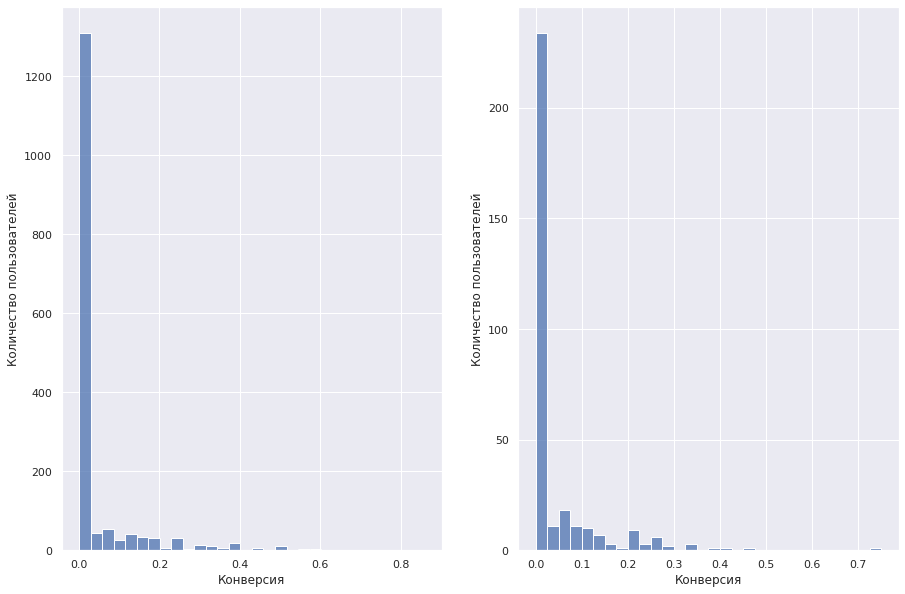

In [116]:
fig = plt.figure(figsize=(15,10))
area = fig.add_subplot(1, 2, 1)
ax = sns.histplot(search_conversion['conversion'], bins = 30)
ax.set_xlabel("Конверсия")
ax.set_ylabel("Количество пользователей")


area = fig.add_subplot(1, 2, 2)
ax=sns.histplot(tips_conversion['conversion'], bins = 30)
ax.set_xlabel("Конверсия")
ax.set_ylabel("Количество пользователей");

Сформулируем гипотезы:
- Н0: Конверсия в целевое действие пользователей, использующих поиск и нажимающих на предложенные объявления, равна
- Н1: Конверсия пользователей имеет статистические различия

In [117]:
alpha = 0.05

results = st.ttest_ind(
    search_conversion['conversion'], 
    tips_conversion['conversion'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5664784939430906
Не получилось отвергнуть нулевую гипотезу


In [118]:
print('Средняя конверсия в целевое действие у пользователей, использующих поиск: {:.2%}'.format(search_conversion['conversion'].mean()))
print('Средняя конверсия в целевое действие у пользователей, нажавних на предложенное объявление: {:.2%}'.format(tips_conversion['conversion'].mean()))

Средняя конверсия в целевое действие у пользователей, использующих поиск: 4.44%
Средняя конверсия в целевое действие у пользователей, нажавних на предложенное объявление: 4.05%


#### Выводы:
- При проверке гипотезы о равенстве конверсий пользователей, пришедших из каналов google и yandex, не удалось отвергнуть нулевую гипотезу, а значит, может сделать вывод, что статстических значимых различий между конверсией каналов нет

- При проверке гипотезе о равенстве конверсий пользователей, использующих поиск(search) и клик по рекомендованному объявления(tips_click), не удалось отвергнуть нулевую гипотезу, азначит, можно сделать вывод, что статистических значемых различий между конверсиями нет

### Итоговый вывод и рекомендации

Был проведен анализ действий пользователей с 07.10.19 по 03.11.19 в мобильном приложения "Ненужные вещи"
Можно подвести итоги:
- к 4ой недели приложение теряет 90% пользователей, совершивших действие на 1ой неделе исследлвания
- среднее время одной сессии - 9 минут, а средняя время в приложении за время анализа - 14 минут, также стоит обратить внимания на действия с 0 длительностью (search,tips_show, map)
- конверсия пользователей за указанный период составила 23%
- не обнаружено зависимостей в удержании пользователей в зависимости от времени суток
- целевой стала группа №2(дневная) с конверсией в 24%
- нет статистических различий конверсии пользователей , пришедших из google и yandex
- нет статистических различий конверсии пользователей, использующих поиск и нажимающих на предложенное объявление


Рекомендации:
- стоит обратить внимание на удержание пользователей, потратить ресурсы на дизайн и интерфейс или алгоритмы для подбора объявлений, для увеличения коэффициента удержания
- разобрать алгоритм работы search, tips_show,map  т.к. большая часть сессий с нулевой длительность приходится на эти события, возможна техническая ошибка